# Lucata Simulation and Plotting Tools

### Lesson Objectives

Upon completing this notebook you should be able to understand and apply the following concepts:

1) Run a simulation with timing that generates statistics for plotting.  
2) Evaluate the outputs from plotting scripts.  
3) Look at two different kinds of spawn primitives and compare them using their plots.  

### Environment Setup

In [1]:
#As with the previous notebook we set up the environment for tools to be used in this notebook. From the command line you can source the ../.env script.
import os

#Set the path to the latest toolset 
LUCATA_BASE="/tools/emu/pathfinder-sw/22.09-beta" 

os.environ["USER_NOTEBOOK_CODE"]=os.path.dirname(os.getcwd())
os.environ["PATH"]=os.pathsep.join([os.path.join(LUCATA_BASE,"bin"),os.environ["PATH"]])
os.environ["FLAGS"]="-I"+LUCATA_BASE+"/include/"+" -L"+LUCATA_BASE+"/lib -lmemoryweb"

### Running Simulations for Profiling  

First we build all versions of `hello-world-*.c`. Then we will demonstrate how to run simulations and run each step of the profiling meta-script, `emusim_profile`.

In [2]:
%%bash
set -x
ls -l hello-world*.c
. ../.env
make all
set +x

-rw-r----- 1 jyoung9 gtperson 1333 Sep 21 21:20 hello-world.c
-rw-r----- 1 jyoung9 gtperson 1169 Sep 21 20:54 hello-world-spawn-at.c
-rw-r----- 1 jyoung9 gtperson 1128 Sep 21 20:54 hello-world-spawn.c
Lucata tools are added to current path from /tools/lucata/pathfinder-sw/22.09-beta
Using Lucata toolchain at /tools/lucata/pathfinder-sw/22.09-beta.


+ ls -l hello-world.c hello-world-spawn-at.c hello-world-spawn.c
+ . ../.env
++ LUCATA_VERSION=22.09-beta
++ export LUCATA_BASE=/tools/lucata/pathfinder-sw/22.09-beta
++ LUCATA_BASE=/tools/lucata/pathfinder-sw/22.09-beta
++ PATH=/tools/lucata/pathfinder-sw/22.09-beta/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin
++ LD_LIBRARY_PATH=/tools/lucata/pathfinder-sw/22.09-beta/lib:/usr/lib64:/usr/lib/x86_64-linux-gnu/
++ USER=
++ echo 'Lucata tools are added to current path from /tools/lucata/pathfinder-sw/22.09-beta'
+ make all
+ set +x


Manually run the simulator and generate all the plots.

In [3]:
%%bash
set -x;
mkdir -p manual_plots;
cd manual_plots;
emusim.x --capture_timing_queues -m 24 --total_nodes 2 --output_instruction_count -- ../hello-world.mwx;
make_tqd_plots.py hello-world.tqd;
make_map_plots.py hello-world.mps;
make_uis_plots.py hello-world.uis;
make_hpc_plots.py -f hello-world.hpc;
set +x;

Start untimed simulation with local date and time= Wed Sep 21 21:21:30 2022

Timed simulation starting...
Hello, world!
End untimed simulation with local date and time= Wed Sep 21 21:21:42 2022


Info: /OSCI/SystemC: Simulation stopped by user.
Generating hello-world.MSP_Activity.png
Generating hello-world.SRIO_Outgoing_Activity.png
Generating hello-world.SRIO_Incoming_Activity.png
Generating hello-world.Live_Threads.png
Generating hello-world.Thread_Enqueue_Map.png
Generating hello-world.Memory_Read_Map.png
Generating hello-world.Memory_Write_Map.png
Generating hello-world.Atomic_Transaction_Map.png
Generating hello-world.Remote_Transaction_Map.png
Generating hello-world_total_instructions.png
Generating hello-world_total_migrations.png
Find all graphs in: ./hello-world_21-09-2022_21:22:06
The last hpc call to analyze will be 0
Program called lu_profile_perfcntr with message: HELLO WORLD STOPPING COUNTERS AT END
Generating Graphs for [HELLO WORLD STOPPING COUNTERS AT END]...
Stopping 

+ mkdir -p manual_plots
+ cd manual_plots
+ emusim.x --capture_timing_queues -m 24 --total_nodes 2 --output_instruction_count -- ../hello-world.mwx

        SystemC 2.3.3-Accellera --- Sep  7 2022 09:15:59
        Copyright (c) 1996-2018 by all Contributors,
        ALL RIGHTS RESERVED
+ make_tqd_plots.py hello-world.tqd
+ make_map_plots.py hello-world.mps
+ make_uis_plots.py hello-world.uis
+ make_hpc_plots.py -f hello-world.hpc
/tools/emu/pathfinder-sw/22.09-beta/bin/make_hpc_plots.py:121: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplotX, subplotY, subplotNum)  # place the graph in the correct subplot in the figure
/tools/emu/pathfinder-sw/22.09-beta/bin/make_hpc_plots.py:177: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/tools/emu/pathfinder-sw

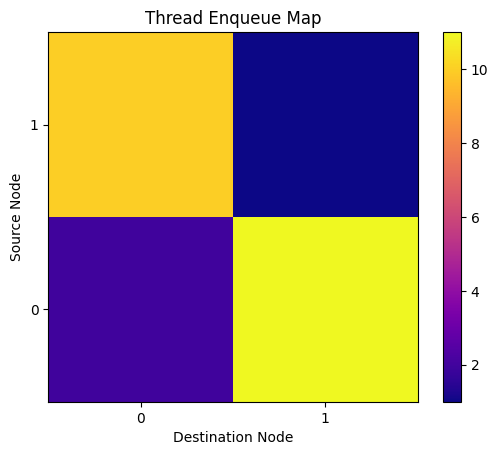

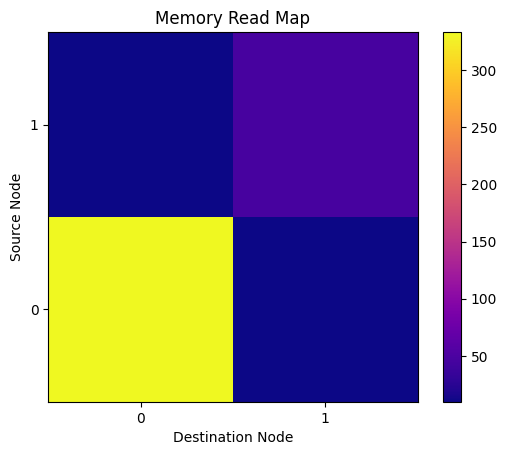

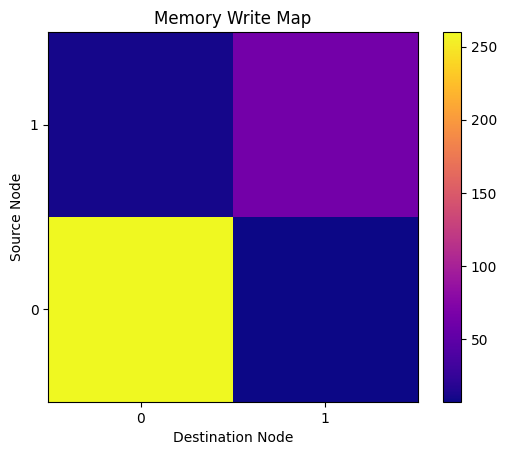

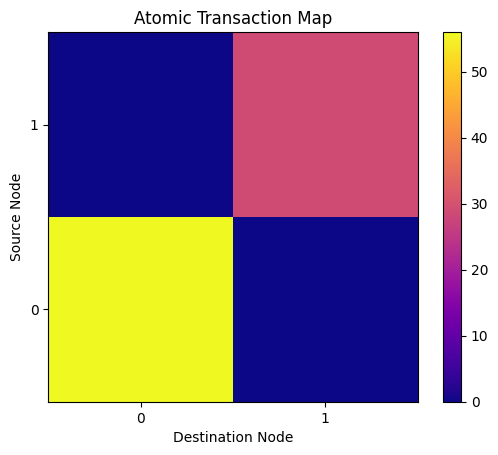

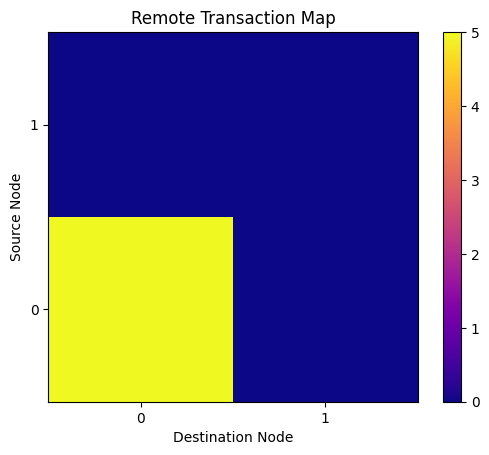

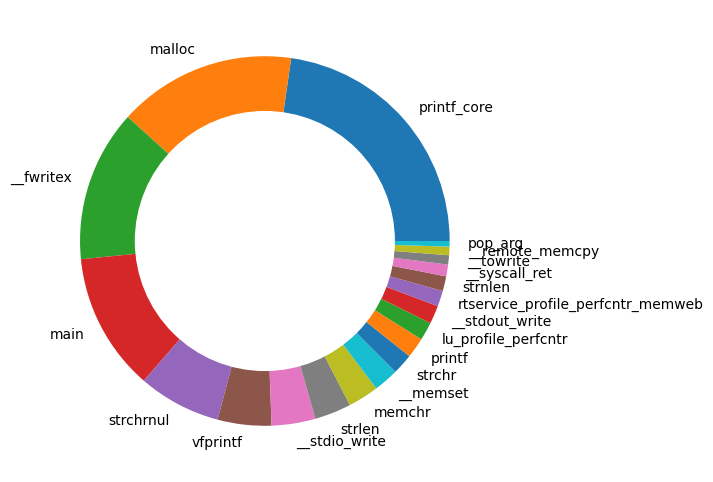

In [4]:
from IPython.display import Image, display

display(Image(filename="manual_plots/hello-world.Thread_Enqueue_Map.png"))
display(Image(filename="manual_plots/hello-world.Memory_Read_Map.png"))
display(Image(filename="manual_plots/hello-world.Memory_Write_Map.png"))
display(Image(filename="manual_plots/hello-world.Atomic_Transaction_Map.png"))
display(Image(filename="manual_plots/hello-world.Remote_Transaction_Map.png"))
display(Image(filename="manual_plots/hello-world_total_instructions.png"))

Use the `emusim_profile` wrapper to generate these with a single command.  
The directory `profile_hello-world` is where the outputs will be generated.
The wrapper inputs are as follows:
```
emusim_profile <profile directory> [<emusim options>] -- mybenchmark.mwx --param 1 --param 2
```
Note: The profiler uses the following simulator flags, so they should not be passed into the profiler:  
`-o, --capture_timing_queues, --output_instruction_count`.

In [5]:
%%bash
mkdir -p profile_hello-world;
emusim_profile profile_hello-world --total_nodes 2 -m 24 -- hello-world.mwx

Generating profile in profile_hello-world/hello-world
emusim.x  --total_nodes 2 -m 24
hello-world.mwx
Start untimed simulation with local date and time= Wed Sep 21 21:22:50 2022

Timed simulation starting...
Hello, world!
End untimed simulation with local date and time= Wed Sep 21 21:23:00 2022


Info: /OSCI/SystemC: Simulation stopped by user.
Generating profile_hello-world/hello-world_total_instructions.png
Generating profile_hello-world/hello-world_total_migrations.png
Generating profile_hello-world/hello-world.Thread_Enqueue_Map.png
Generating profile_hello-world/hello-world.Memory_Read_Map.png
Generating profile_hello-world/hello-world.Memory_Write_Map.png
Generating profile_hello-world/hello-world.Atomic_Transaction_Map.png
Generating profile_hello-world/hello-world.Remote_Transaction_Map.png
Generating profile_hello-world/hello-world.MSP_Activity.png
Generating profile_hello-world/hello-world.SRIO_Outgoing_Activity.png
Generating profile_hello-world/hello-world.SRIO_Incoming_Act


        SystemC 2.3.3-Accellera --- Sep  7 2022 09:15:59
        Copyright (c) 1996-2018 by all Contributors,
        ALL RIGHTS RESERVED
/net/tools/emu/pathfinder-sw/22.09-beta/bin/make_hpc_plots.py:121: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplotX, subplotY, subplotNum)  # place the graph in the correct subplot in the figure
/net/tools/emu/pathfinder-sw/22.09-beta/bin/make_hpc_plots.py:177: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/net/tools/emu/pathfinder-sw/22.09-beta/bin/make_hpc_plots.py:177: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


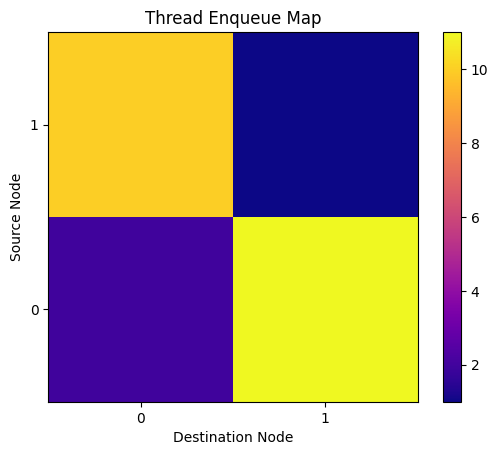

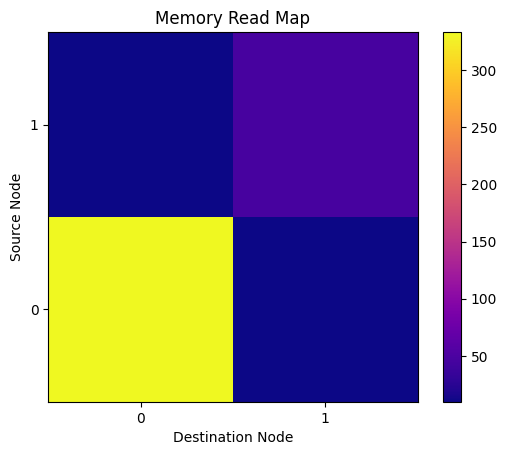

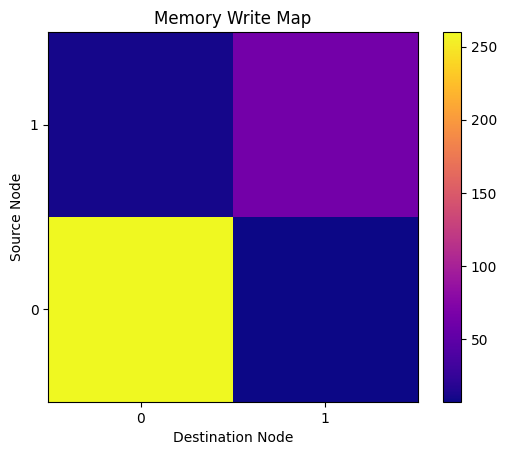

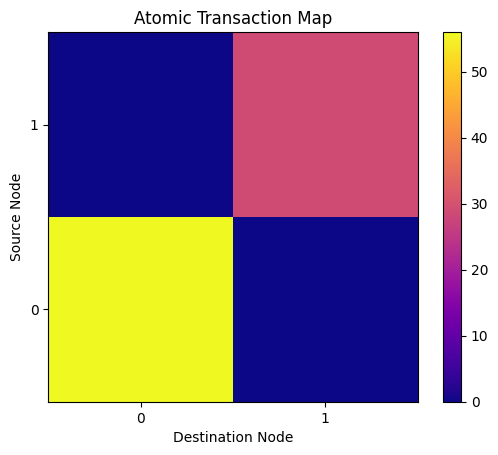

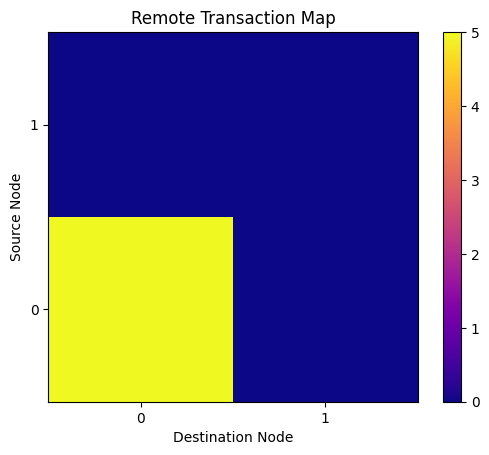

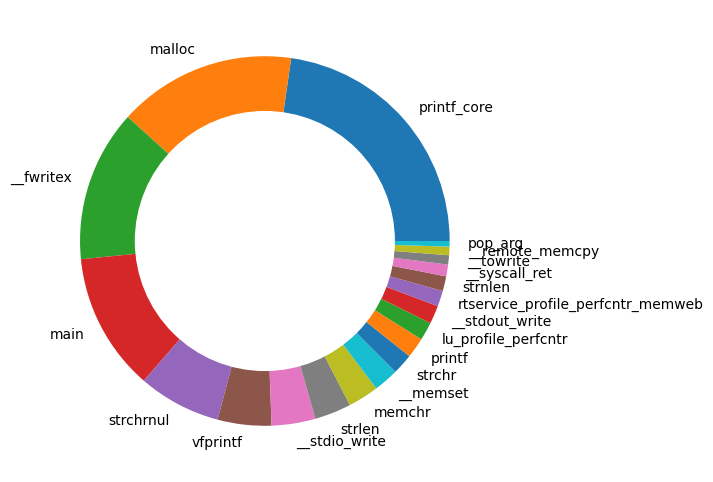

In [6]:
display(Image(filename="profile_hello-world/hello-world.Thread_Enqueue_Map.png"))
display(Image(filename="profile_hello-world/hello-world.Memory_Read_Map.png"))
display(Image(filename="profile_hello-world/hello-world.Memory_Write_Map.png"))
display(Image(filename="profile_hello-world/hello-world.Atomic_Transaction_Map.png"))
display(Image(filename="profile_hello-world/hello-world.Remote_Transaction_Map.png"))
display(Image(filename="profile_hello-world/hello-world_total_instructions.png"))

In [7]:
!ls hello-world.*

hello-world.c  hello-world.mwx


We now have several different output files. These are detailed in Ch. 7.6 of the Programming Guide and are as follows:
* hello-world.mwx - Lucata executable.
* hello-world.cdc - Configuration data output file; includes system information and wall-clock time.
* hello-world.mps - Memory map output; shows memory operation types and thread enqueuing.
* hello-world.tqd - Timed activity tracing; includes live threads, thread activity counts, and requests.
* hello-world.uis - Instruction count statistics; shows the number of instructions per function in the application and number of migrations.

These files can be used with plotting tools to provide detailed output on the simulation of the application.

## Hello World Spawn Example

That example kept one thread alive and migrating between nodelets.  This one, hello-world-spawn.c, uses Cilk's thread spawning intrinsic:

```c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <cilk.h>

#include <memoryweb.h>
#include <timing.h>

const char str[] = "Hello, world!";

static inline void copy_ptr (char *pc, const long *pl) { *pc = (char)*pl; }

replicated long * ptr;
replicated char * str_out;

int main (void)
{
     long n = strlen (str) + 1;

     mw_replicated_init ((long*)&ptr, (long)mw_malloc1dlong (n));
     mw_replicated_init ((long*)&str_out, (long)malloc (n * sizeof (char)));

     /*
      * Start timing here.
      * Profiler settings hidden for simplicity.
      */

     for (long k = 0; k < n; ++k)
          ptr[k] = (long)str[k]; // Remote writes

     for (long k = 0; k < n; ++k)
          cilk_spawn copy_ptr (&str_out[k], &ptr[k]);

     cilk_sync;

     printf("%s\n", str_out);  // Migration back
     
     // Profiler end commands.
     
     return 0;
}
```

In [8]:
%%bash
mkdir -p profile_hello-world-spawn;
emusim_profile profile_hello-world-spawn --total_nodes 2 -m 24 -- hello-world-spawn.mwx
ls profile_hello-world-spawn/hello-world-spawn*

Generating profile in profile_hello-world-spawn/hello-world-spawn
emusim.x  --total_nodes 2 -m 24
hello-world-spawn.mwx
Start untimed simulation with local date and time= Wed Sep 21 21:24:16 2022

Timed simulation starting...
Hello, world!
End untimed simulation with local date and time= Wed Sep 21 21:24:27 2022


Info: /OSCI/SystemC: Simulation stopped by user.
Generating profile_hello-world-spawn/hello-world-spawn_total_instructions.png
Generating profile_hello-world-spawn/hello-world-spawn_total_migrations.png
Generating profile_hello-world-spawn/hello-world-spawn.Thread_Enqueue_Map.png
Generating profile_hello-world-spawn/hello-world-spawn.Memory_Read_Map.png
Generating profile_hello-world-spawn/hello-world-spawn.Memory_Write_Map.png
Generating profile_hello-world-spawn/hello-world-spawn.Atomic_Transaction_Map.png
Generating profile_hello-world-spawn/hello-world-spawn.Remote_Transaction_Map.png
Generating profile_hello-world-spawn/hello-world-spawn.MSP_Activity.png
Generating profi


        SystemC 2.3.3-Accellera --- Sep  7 2022 09:15:59
        Copyright (c) 1996-2018 by all Contributors,
        ALL RIGHTS RESERVED
/net/tools/emu/pathfinder-sw/22.09-beta/bin/make_hpc_plots.py:121: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplotX, subplotY, subplotNum)  # place the graph in the correct subplot in the figure
/net/tools/emu/pathfinder-sw/22.09-beta/bin/make_hpc_plots.py:177: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
/net/tools/emu/pathfinder-sw/22.09-beta/bin/make_hpc_plots.py:177: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


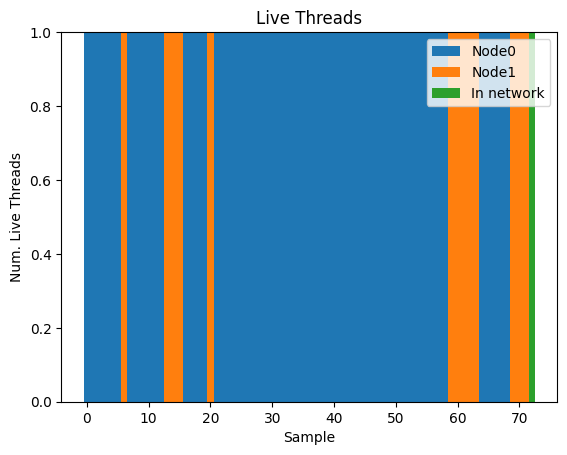

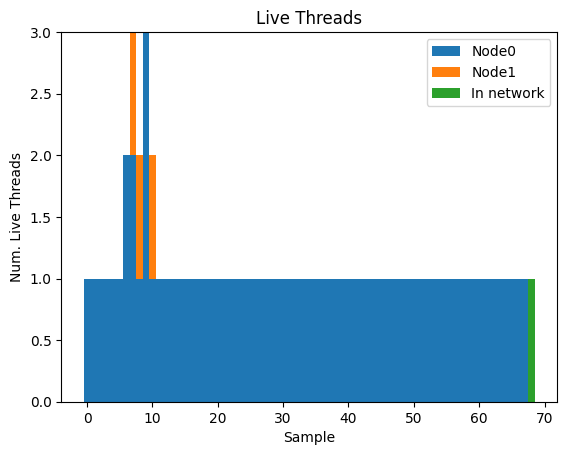

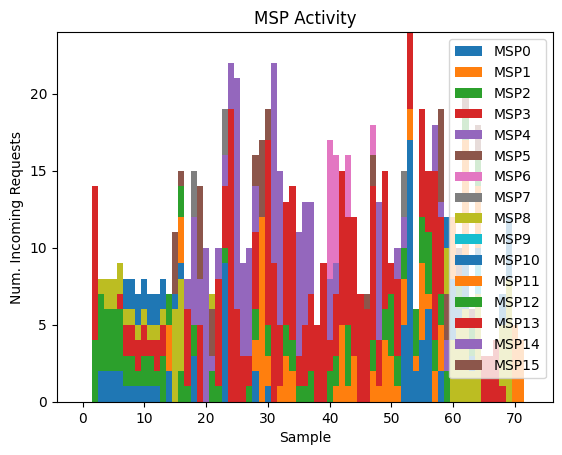

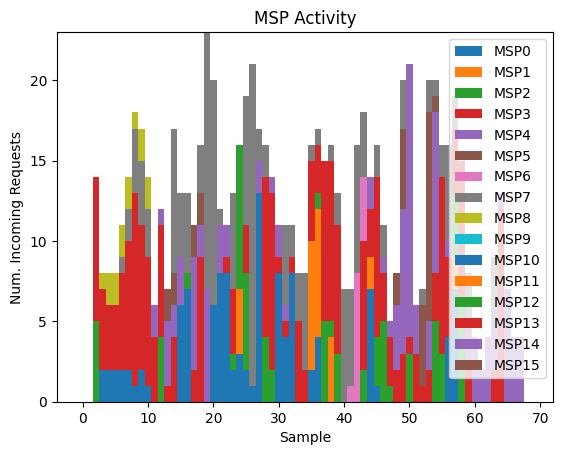

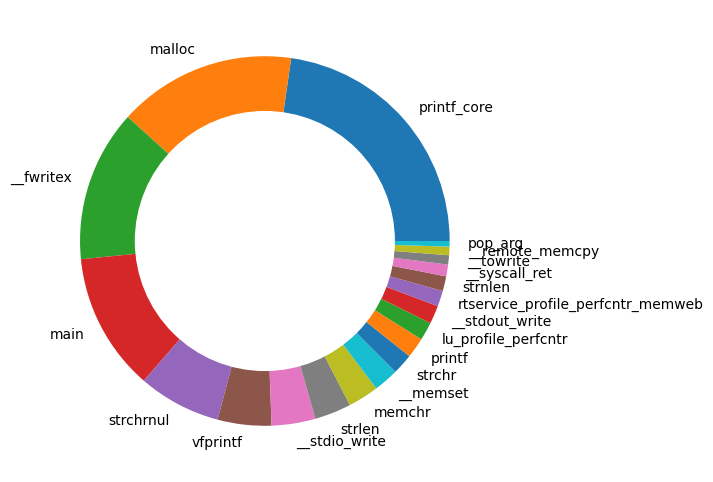

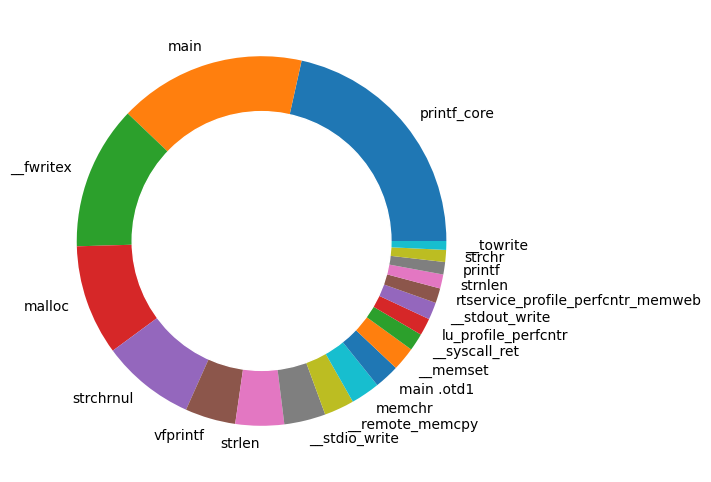

In [9]:
display(Image(filename="profile_hello-world/hello-world.Live_Threads.png"))
display(Image(filename="profile_hello-world-spawn/hello-world-spawn.Live_Threads.png"))
#display(Image(filename="profile_hello-world/hello-world.Thread_Activity.png"))
#display(Image(filename="profile_hello-world-spawn/hello-world-spawn.Thread_Activity.png"))
display(Image(filename="profile_hello-world/hello-world.MSP_Activity.png"))
display(Image(filename="profile_hello-world-spawn/hello-world-spawn.MSP_Activity.png"))
display(Image(filename="profile_hello-world/hello-world_total_instructions.png"))
display(Image(filename="profile_hello-world-spawn/hello-world-spawn_total_instructions.png"))

Then we can compare the output of the normal Hello World and the Spawn Hello World for the statistics that are different.

## Advanced Implementation - Spawn At

This example just shows one additional variation of using a `cilk_spawn_at` call to spawn threads at a remote node

```c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <cilk.h>

#include <memoryweb.h>
#include <timing.h>

static const char str[] = "Hello, world!";

static inline void copy_ptr (char *pc, const long *pl) { *pc = (char)*pl; }

replicated long * ptr;
replicated char * str_out;

int main (void)
{
     long n = strlen (str) + 1;

     mw_replicated_init ((long*)&ptr, (long)mw_malloc1dlong (n));
     mw_replicated_init ((long*)&str_out, (long)malloc (n * sizeof (char)));

     /*
      * Start timing here.
      * Profiler settings hidden for simplicity.
      */

     for (long k = 0; k < n; ++k)
          ptr[k] = (long)str[k]; // Remote writes

     for (long k = 0; k < n; ++k) {
          cilk_spawn_at(&ptr[k]) copy_ptr (&str_out[k], &ptr[k]);
     }

     cilk_sync;
    
     printf("%s\n", str_out);  // Migration back
    
     // Profiler end commands.
    
     return 0;
}
```

In [10]:
%%bash
mkdir -p profile_hello-world-spawn-at;
emusim_profile profile_hello-world-spawn-at --total_nodes 2 -m 24 -- hello-world-spawn-at.mwx
ls profile_hello-world-spawn-at/hello-world-spawn-at*

Generating profile in profile_hello-world-spawn-at/hello-world-spawn-at
emusim.x  --total_nodes 2 -m 24
hello-world-spawn-at.mwx
Start untimed simulation with local date and time= Wed Sep 21 21:25:35 2022

Timed simulation starting...
Hello, world!
End untimed simulation with local date and time= Wed Sep 21 21:25:47 2022


Info: /OSCI/SystemC: Simulation stopped by user.
Generating profile_hello-world-spawn-at/hello-world-spawn-at_total_instructions.png
Generating profile_hello-world-spawn-at/hello-world-spawn-at_total_migrations.png
Generating profile_hello-world-spawn-at/hello-world-spawn-at.Thread_Enqueue_Map.png
Generating profile_hello-world-spawn-at/hello-world-spawn-at.Memory_Read_Map.png
Generating profile_hello-world-spawn-at/hello-world-spawn-at.Memory_Write_Map.png
Generating profile_hello-world-spawn-at/hello-world-spawn-at.Atomic_Transaction_Map.png
Generating profile_hello-world-spawn-at/hello-world-spawn-at.Remote_Transaction_Map.png
Generating profile_hello-world-spawn-


        SystemC 2.3.3-Accellera --- Sep  7 2022 09:15:59
        Copyright (c) 1996-2018 by all Contributors,
        ALL RIGHTS RESERVED
/net/tools/emu/pathfinder-sw/22.09-beta/bin/make_hpc_plots.py:121: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplotX, subplotY, subplotNum)  # place the graph in the correct subplot in the figure
/net/tools/emu/pathfinder-sw/22.09-beta/bin/make_hpc_plots.py:177: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
/net/tools/emu/pathfinder-sw/22.09-beta/bin/make_hpc_plots.py:177: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


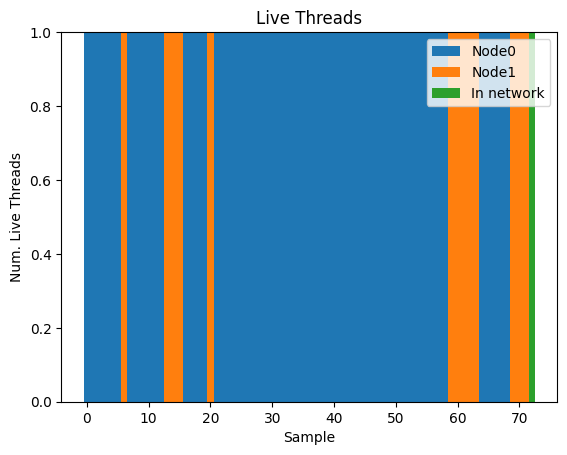

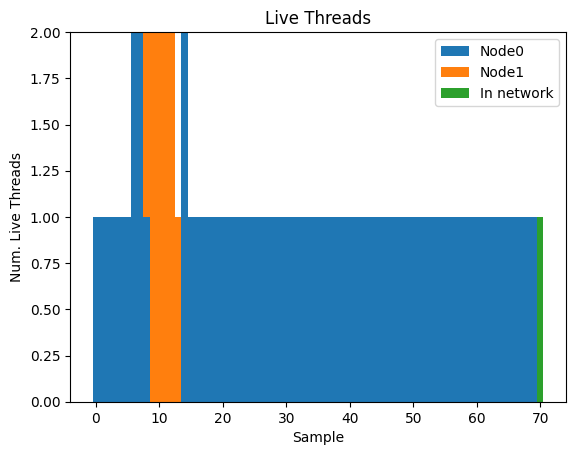

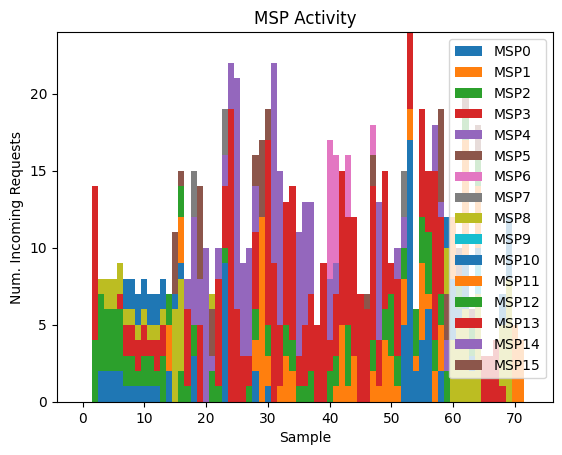

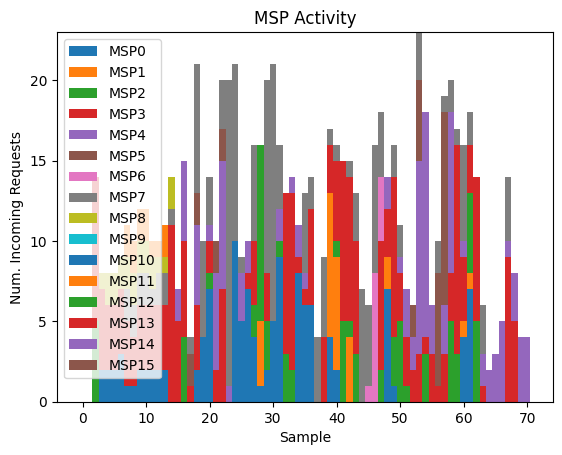

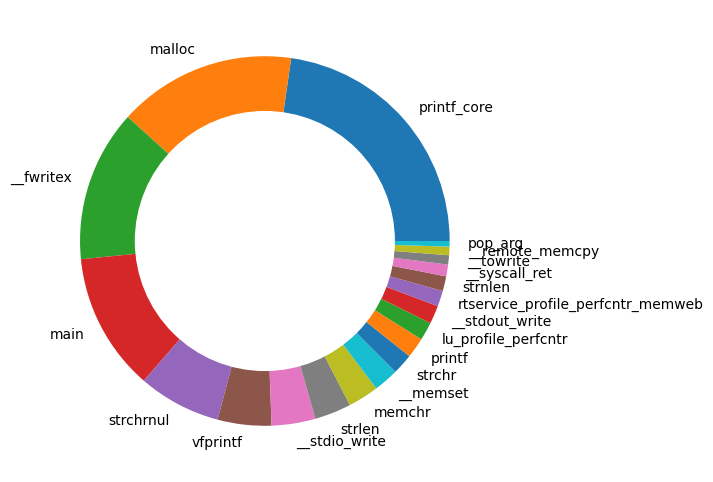

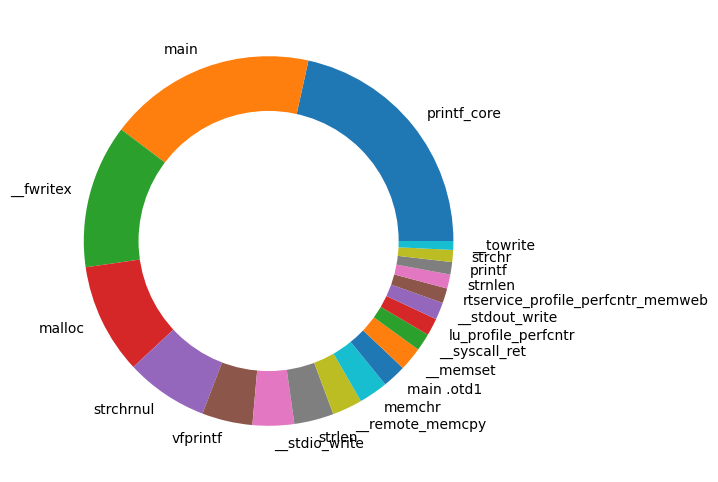

In [11]:
display(Image(filename="profile_hello-world/hello-world.Live_Threads.png"))
display(Image(filename="profile_hello-world-spawn-at/hello-world-spawn-at.Live_Threads.png"))
#display(Image(filename="profile_hello-world/hello-world.Thread_Activity.png"))
#display(Image(filename="profile_hello-world-spawn-at/hello-world-spawn-at.Thread_Activity.png"))
display(Image(filename="profile_hello-world/hello-world.MSP_Activity.png"))
display(Image(filename="profile_hello-world-spawn-at/hello-world-spawn-at.MSP_Activity.png"))
display(Image(filename="profile_hello-world/hello-world_total_instructions.png"))
display(Image(filename="profile_hello-world-spawn-at/hello-world-spawn-at_total_instructions.png"))

Once we've finished our testing, we can then clean up some of the logfiles that we used for this example.

In [12]:
!make clean

rm -f *.mwx *.tqd *.cdc *.vsf *.mps *.uis *.csv *.hpc; \
./helpers/backup_imgs.sh
